# AB-testing by clusters

## How to run experiments on small data sets
[Bertil Hatt](https://www.linkedin.com/in/bertilhatt/) & [João F. Martins](https://www.linkedin.com/in/joão-fidalgo-martins-8837b07a
) — [Farfech](https://www.farfetchtechblog.com/en/)

## This presentation is relevant if you are curious about:
- AB-tests _aka_ Double-blind randomised control trials
- Python code running this test
- on small samples
  - Experimental treatment, few patients
  - New company, B2B or market-place
  - External constraints, _e.g._ relations, OTL, enrollment

Constraints are often expressed as *clusters* of observations. Another name for that pattern is *quasi-experiments*.

## Contents
<a name="contents_1"></a>

[**AB-test**](#intro)
* [Principle of a statitical test](#principles)
* [Monitoring with AA tests](#aa_tests)
* [Sensitivity tests](#sensitivity)

[**Complications**](#complications)
* [Choosing a test unit](#unit_selection)
* [Non-logged in users](#id_post_exposure)
* [Overlapping experiments](#overlap)

[**Small sample**](#small_sample)
* [Re-shuffling the random split](#reshuffle)
* [Control for type and activity](#type_activity)
* [Excluding outliers](#outliers)

[Summary](#summary)


# Why run experiments when you have small samples
<a name="intro"></a>


## Why AB tests (in general)?
- Measuring when circumstances changes too
- Multiple simultaneous interferring tests
- Explicit precision over impact measure

## Relevant use cases
- Early clinical tests with few patients
- New company, B2B with few partners
  - Blockier sides of a multisided market
- Quasi experiment _aka_ Experiment by cluster

## Does it make sense to test on small sample?
  - Yes, but “low power”: test can only detect strong effect
  - Manage expectations stakeholders, control the test split

# How to run a test
<a name="principles"></a>

## Define your experiment

### Population, treatment, objective metric, minimum relevant impact
- Define population, isolate independent unit
- Control _vs._ Treatment 
- Objective metric
  - simplified to conversion rate: Observations and Conversions
- Relevant impact: Minimum detectable effect and duration

### Statistical test – Simplified

We estimate the Conversion rate for control and treatment in their respective sample.

$$ \hat{CR_C} = \frac{\#conv_C}{\#obs_C} \quad \hat{CR_T} = \frac{\#conv_T}{\#obs_T}$$ 

the variance of the conversion rate for control is:
$$ \hat V \left(\hat{CR_C}\right) = \frac{\hat{CR_C}(1-\hat{CR_C})}{\#obs_C} $$

the variance for the difference is :
$$ \hat V \left(d_{C-T}\right) =
   \hat V \left(\hat{CR_C} - \hat{CR_T}\right) =
\frac{\hat{CR_C}(1-\hat{CR_C})}{\#obs_C} + \frac{\hat{CR_T}(1-\hat{CR_T})}{\#obs_T} $$

while the standard deviation of the difference is:
$$ \hat\sigma\left(\hat{d_{C-T}}\right) =
\sqrt{\frac{\hat{CR_C}(1-\hat{CR_C})}{\#obs_C} +
      \frac{\hat{CR_T}(1-\hat{CR_T})}{\#obs_T}} $$


We consider the difference to be **significant** by proving wrong the no-difference hypothesis:
- if we assume Control and Treatment are the same,
- would the difference only happen in the 5% most eggregious cases?

  _i.e._ Is the difference in conversion rate **outside of the confidence interval** for Control?

For $\alpha = 5\%$, that means $ z_{1-\alpha/2} = 1.96 $ standard deviations on either side of the estimate.

$$ \hat{d_{C-T}} \in \left[ 0 \pm z.\hat\sigma\left(\hat{d_{C-T}}\right)\right] $$

### Statistical test – Simplified (Continued)

We can also express the test with a $t$-score and a $p$-value: 

- $t$ is the number of standard deviation observed, _i.e._ $$ \hat{t} = \frac{\hat{d_{C-T}}}{\sigma\left(\hat{d_{C-T}}\right)} $$
- $p$ is the probability that our data would be at least this inconsistent given our hypothesis. It’s typically computed using known distribution function.

### Caveat

We are assuming that:
1. we observe at most one conversion per observation;
  - This is not true for test on non-binary quantities.
1. there are enough observations in total and;
1. the conversion rate is far enough from zero  
   for a Bernoulli sample to be assumed Gaussian;
  - This is not true for small samples.
1. each observation (and conversion) is independent;
  - This might not be true if event can be grouped.

Most of those assumptions will be challenged further down.  

### Minimal detectable effect

Given $p_C = \hat{CR_C}, p_T = \hat{CR_T} $ and an agreed $z$, the **minimal detectable effect** (MDE) is

$$ \begin{align}
MDE & = z.\hat\sigma(d_{C-T}) \\
& = z \sqrt{\frac{p_C(1-p_C)}{\#obs_C}+\frac{p_T(1-p_T)}{\#obs_T}}
\end{align}$$

therefore, assuming that we have a balanced segment ($\#obs_C = \#obs_T$) and that we have a rought estimation $p$ of $p_C$ and $p_T$, we can compute how many observations are needed for a test to reach a relevant minimal detectable effect:

$$ \begin{align}
MDE \quad = & \quad  z \sqrt{\frac{p(1-p)}{\#obs_C}+\frac{p(1-p)}{\#obs_T}}\\
 \quad \approx & \quad z \sqrt{2 \frac{p(1-p)}{\#obs_C}} \\
\#obs_C \quad \approx  & \quad 2 p(1-p)\left(\frac{z}{MDE}\right)^2 \\
\#obs \quad = \quad \#obs_T + \#obs_C \quad \approx & \quad 4 p(1-p)\left(\frac{z}{MDE}\right)^2
\end{align}$$


For a MDE twice more refined, you’ll need four times more observations.

The expected test **duration** is inferred from the expected traffic.

# Random generation

<a name="random_generation"></a>

We need to create fake data for the purpose of this presentation

### Generate random values

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

def date_from_value(value, start = "2019-01-01", end = "2019-07-01"):
    """
    Given a value between 0 and 1,
    Returns a datetime between two dates (as string)
    """
    # TODO: more realistic time of day
    start = dt.datetime.strptime(start, '%Y-%m-%d')
    end = dt.datetime.strptime(end, '%Y-%m-%d')
    duration_sec = value * ((end - start).days*24*60*60)
    return start + dt.timedelta(seconds=duration_sec)

In [2]:
def generate_observation_and_conversion(
    conversion_rate = 0.3,
    nb_users= 400,
    nb_events = 1000,
    pareto_parameter_conversion_delay = .4,
):
    """
    Given parameters about a population,
    Returns a list of random events, with a possible conversion and delay
    """
    random_dates = pd.Series(np.random.random(size=(nb_events)))
    random_dates = random_dates.apply(date_from_value)
    random_users = pd.Series(np.random.randint(nb_users, size=(nb_events)))
    random_convs = pd.Series(np.random.rand(nb_events) < conversion_rate)
    random_conv_delay = pd.Series(np.random.pareto(
        pareto_parameter_conversion_delay, size=(nb_events)
    ))
    random_events = pd.concat([
        random_dates, random_users, random_convs, random_conv_delay,
    ], axis=1, sort=False)
    random_events.columns = ["event_timestamp", "user_id", "conversion", "conversion_delay",]
    return random_events

In [3]:
random_events = generate_observation_and_conversion()
random_events.head()

,event_timestamp,user_id,conversion,conversion_delay
0,2019-02-19 08:12:16.503327,85,False,7.884838
1,2019-03-10 13:03:01.713686,212,True,1.730238
2,2019-01-21 05:00:52.272784,331,False,5.761928
3,2019-02-16 00:13:35.463049,77,False,2061.644412
4,2019-03-10 01:11:22.093202,180,True,2.525923


In [4]:
def generate_conversion_from_observation(random_events):
    """
    Given a set of events with possible conversions
    Return the table of conversions
    """
    convertions = random_events[random_events["conversion"]]
    if len(convertions) > 0:
        convertions = convertions.assign(
            event_timestamp = convertions.apply(
                lambda row: row["event_timestamp"] + dt.timedelta(
                    minutes=min(row["conversion_delay"], 24*60*60)
                    # If conversion_delay is too high, type can overflod
                ),
            axis=1))
    return convertions[["event_timestamp", "user_id"]]

In [5]:
random_convertions = generate_conversion_from_observation(random_events)
random_convertions.head(3)

,event_timestamp,user_id
1,2019-03-10 13:04:45.527989,212
4,2019-03-10 01:13:53.648610,180
7,2019-02-26 04:10:23.441957,111


In [6]:
def generate_events(cr=.3, n_users=400, n_obs=1_000, pp=.4):
    """
    Given optional key parameters about an set of events
    Return a sample set of events with observations and conversions
    """
    observation = generate_observation_and_conversion(cr, n_users, n_obs, pp)
    convertions = generate_conversion_from_observation(observation)
    observation = observation[["event_timestamp", "user_id"]]
    observation = observation.assign(event_type = "observation")
    convertions = convertions.assign(event_type = "conversion")
    events = pd.concat([observation, convertions], axis=0)    
    events = events.sort_values(by=["event_timestamp"]).reset_index(drop=True)
    return events

In [7]:
events = generate_events()
events.head()

,event_timestamp,user_id,event_type
0,2019-01-01 03:56:51.245109,147,observation
1,2019-01-01 06:18:31.745709,84,observation
2,2019-01-01 11:56:20.170313,234,observation
3,2019-01-01 17:21:51.696596,64,observation
4,2019-01-01 17:34:03.043350,64,conversion


In [8]:
options = ["control", "treatment"]
def generate_segment_from_events(events=generate_events(), options=options):
    """
    Given events and an optional list of alternative options
    Returns balanced assignement to each segment
    """
    creation = pd.DataFrame(events.groupby("user_id")["event_timestamp"].min())    
    assignment = np.random.choice(options, len(creation))
    creation = creation.assign(segment = assignment)
    creation.columns = ["assignment_timestamp", "segment"]
    return creation

In [9]:
segment = generate_segment_from_events()
segment.head()

,assignment_timestamp,segment
user_id,,
1,2019-02-26 13:34:25.967022,control
2,2019-01-12 03:19:14.204799,treatment
3,2019-02-20 09:55:29.089067,control
4,2019-04-04 20:35:49.335652,control
5,2019-02-21 20:56:30.618297,control


## Code 

<a name="code"></a>

### Processing results

In [10]:
events = generate_events() # load_from_database()
segment = generate_segment_from_events(events)
events_with_segment = events.set_index("user_id").join(segment, on="user_id")
totals = events_with_segment.groupby(["segment", "event_type"])["segment"].count()

In [11]:
totals.head()

segment    event_type 
control    conversion     155
           observation    474
treatment  conversion     151
           observation    526
Name: segment, dtype: int64

In [12]:
def compute_totals(events, segment):
    events_with_segment = events.set_index("user_id")\
        .join(segment, on="user_id")
    totals = events_with_segment \
        .groupby(["segment", "event_type"])["segment"].count()
    return totals

In [13]:
events = generate_events()
segment = generate_segment_from_events(events)
totals = compute_totals(events, segment)
totals

segment    event_type 
control    conversion     145
           observation    501
treatment  conversion     159
           observation    499
Name: segment, dtype: int64

In [14]:
from scipy.stats import norm, t
alpha = .1

def var_cr(segment):
    if segment.observation > 0:
        cr = segment.conversion / segment.observation
        var = cr*(1-cr)/segment.observation
        return var, cr
    else:
        return None

def beat_conf_interval(value, conf_interval):
    if value < conf_interval[0]:
        result = "Loose"        
        significant = True
    else:    
        if value > conf_interval[1]:
            result = "Win"
            significant = True
        else:
            result = "Draw"        
            significant = False
    return significant, result

class TTest():
    def __init__(self, totals, alpha=alpha):
        self.totals = totals
        self.alpha = alpha
#         self.cr_c, self.cr_t = None, None
#         self.difference = None
#         self.stddev = None
#         self.conf_interval = None
#         self.result, self.significant = None
#         self.z, self.t, self.p = None, None, None
    def compute(self):
        co = self.totals.control
        tr = self.totals.treatment
        self.observation = co.observation + tr.observation
        var_c, self.cr_c = var_cr(co) 
        var_t, self.cr_t = var_cr(tr)

        # Stats
        self.difference = self.cr_t - self.cr_c
        self.rel_diff = self.difference/self.cr_c
        self.stddev = np.sqrt(var_c + var_t)
        self.z = norm.interval(1-self.alpha)
        self.conf_interval = tuple(i*self.stddev for i in self.z)

        # Results
        self.significant, self.result = \
            beat_conf_interval(self.difference, self.conf_interval)    
        self.t = self.difference/self.stddev
        self.p = 1 - t.cdf(self.t, df=self.observation -2)        
        return self.significant
    
# def compute_test_results(totals, alpha=alpha):
#     var_c, cr_c = var_cr(totals.control) 
#     var_t, cr_t = var_cr(totals.treatment)
#     stdev = np.sqrt(var_c + var_t)
#     z = norm.interval(1-alpha)
#     diff = cr_c - cr_t    
#     return diff, (z[0]*stdev, z[1]*stdev), (cr_c, cr_t) 
#     # stdev

# def compute_test_stats(results, alpha=alpha):

#     diff, (z[0]*stdev, z[1]*stdev), (cr_c, cr_t) 
#     result[0], result[1]


# def compute_test_significant(result):
#     if result is None:
#         return None        
#     else:
#         return (result[0] < result[1][0]) or (result[0] > result[1][1])

In [15]:
# result = compute_test_results(totals)
# significant = compute_test_significant(result)
# result, significant
t_test = TTest(totals)
t_test.compute()
vars(t_test)

{'totals': segment    event_type 
 control    conversion     145
            observation    501
 treatment  conversion     159
            observation    499
 Name: segment, dtype: int64,
 'alpha': 0.1,
 'observation': 1000,
 'cr_c': 0.2894211576846307,
 'cr_t': 0.3186372745490982,
 'difference': 0.029216116864467456,
 'rel_diff': 0.10094672102826342,
 'stddev': 0.029078813805320878,
 'z': (-1.6448536269514729, 1.6448536269514722),
 'conf_interval': (-0.047830392355128606, 0.047830392355128586),
 'significant': False,
 'result': 'Draw',
 't': 1.0047217558482888,
 'p': 0.15763719285892785}

In [16]:
def format_ci(ci, sep=' '):
    return sep.join(format(lim, '.1%') for lim in ci)

def format_decision(self):
    str = "From {0:.1%} to {1:.1%}, ".format(self.cr_c, self.cr_t)
    str += "a gap of {0:.1%}. ".format(abs(self.difference))
    str += "That is " + ("more" if self.significant else "less") 
    str += " than {0:.1%} and".format(self.conf_interval[1])
    str += (("" if self.significant else " not") + " significant.")
    return str
TTest.format_decision = format_decision

In [17]:
t_test.format_decision()

'From 28.9% to 31.9%, a gap of 2.9%. That is less than 4.8% and not significant.'

In [18]:
# Strong typing
class TypedDataFrame:
    def __init__(self, table):
        self.col_names = None
        self.col_types = None
        self.df = table
    def specify_type(self):
        self.df = pd.DataFrame(self.table, columns=self.col_names)
        for i, col_name in enumerate(self.col_names):
            self.df[col_name].astype(self.col_types[i])

class Events(TypedDataFrame):
    def __init__(self, table):
        self.col_names = ["event_timestamp", "user_id", "event_type", ]
        self.col_types = ['datetime64', 'int', 'category', ]        
        self.specify_type()
    def random_populate(sample_size, p):
        self.df = generate_events()

class Segment(TypedDataFrame):
    def __init__(self, table):
        self.cols = ["timestamp_attribution", "segment", ]
        # user_id is key
        self.col_type = ['datetime64', 'category', ]        
        self.specify_type()
    def random_populate(events, options):
        self.df = generate_segment_from_events(events, options)

## Basic classes

<a name="classes"></a>


In [19]:
class ABTest:
    def __init__(self, events, segment):
        self.events = events # Events(events)
        self.segment = segment # Segment(segment)
    def compute(self):
        self.totals = compute_totals(self.events, self.segment)        
        self.t_test = TTest(self.totals)
        self.t_test.compute()
        self.decision = self.t_test.format_decision()
        return self.t_test.significant

In [20]:
abtest = ABTest(events, segment)
abtest.compute()
abtest.totals

segment    event_type 
control    conversion     145
           observation    501
treatment  conversion     159
           observation    499
Name: segment, dtype: int64

In [21]:
abtest.decision

'From 28.9% to 31.9%, a gap of 2.9%. That is less than 4.8% and not significant.'

### Size-dependence results

The key intuition behind those is that with a larger sample, we could detect more refined effects.

In [22]:
def test_sample_by_size(n_obs=1_000):
    events = generate_events(n_obs=n_obs)
    segment = generate_segment_from_events(events)
    ab_test = ABTest(events, segment)
    ab_test.compute()
    print(ab_test.decision)

In [23]:
test_sample_by_size(n_obs=1_000)

From 27.5% to 27.7%, a gap of 0.1%. That is less than 4.7% and not significant.


In [24]:
test_sample_by_size(n_obs=10_000)

From 30.1% to 31.9%, a gap of 1.7%. That is more than 1.5% and significant.


In [25]:
test_sample_by_size(n_obs=100_000)

From 30.2% to 29.9%, a gap of 0.3%. That is less than 0.5% and not significant.


### Sequential tests

Running test for increasingly longer should improve precision. But running the test repeatedly and acting on any significant result means that we **compound false positives**.

We can reduce the false positive rate for each individual test to a value that compounds up to our desired $\alpha$. This is known as the Sequential Probability Ratio Test (SPRT) We have implemented a sequential approach known as the modified SPRT or **mSPRT**. For details, see [a recent paper by Etsy](https://www.hongliangjie.com/publications/wsdm2019_preprint.pdf)


# AA tests
<a name="aa_test"></a>

### Why run AA test

Is the test detecting non-changes?

### Confusion matrix

|        _             | Actual difference |  No real difference |
| -------------------- |:-----------------:| ------------------- |
| **Test signficant**  | True positive     | False positive      |
| **Test non-signif.** | False negative    | True negative       |


# AA tests and Sensitivity testing

### Why run AA test

Is the test detecting non-changes?

### Confusion matrix

|        _      | *Actual difference* |  No real difference |
| ------------- |:-------------------:| ------------------- |
| Test positive | *True positive*     | **False positive**  |
| Test negative | *False negative*    | True negative       |


### How to run an AA tests

#### Random split and test, repeatedly

- Consider recent past data

- Generate random split

- Test past data with no change

In [26]:
class BatchAATest:
    def __init__(self, events):
        self.events = events
    
    def test_with_random_segment(self):
        self.segment = generate_segment_from_events(self.events)
        self.test = ABTest(self.events, self.segment)
        self.test.compute()
        return self.test
    
    def run_step(self, run_per_step=100):
        self.results = []
        for j in range(run_per_step):
            self.test_with_random_segment()
            self.results.append(self.test.t_test.significant)
        return self.results

    def run_series(self, n_steps=10, run_per_step=100, verbose=True):
        self.aggregate = []
        self.slices = pd.DataFrame([], columns=["false_positive", "nb_aa_test"])
        for i in range(n_steps):
            self.results = self.run_step(run_per_step)
            self.aggregate = [sum(self.results), len(self.results)]
            if verbose:
                print("{0} false positives over {1} AA-tests.".format(*self.aggregate))
            self.slices.loc[len(self.slices)] = self.aggregate
        return self.slices.sum()

In [27]:
events = generate_events()
batch_aa_test = BatchAATest(events)
batch_aa_test.run_series()

13 false positives over 100 AA-tests.
12 false positives over 100 AA-tests.
11 false positives over 100 AA-tests.
15 false positives over 100 AA-tests.
6 false positives over 100 AA-tests.
11 false positives over 100 AA-tests.
7 false positives over 100 AA-tests.
6 false positives over 100 AA-tests.
11 false positives over 100 AA-tests.
7 false positives over 100 AA-tests.


false_positive      99.0
nb_aa_test        1000.0
dtype: float64

We expect a false positive rate of 10%. Is `7 false positives over 100 AA-tests` a sign that there’s something wrong? We need to run thousands of times to have an accurate idea of the _de facto_ false positive rate.

We can treat batches of AA-tests as a meta AB-test when a false positive being a conversion. That way, we can estimate a confidence interval for false positives.

### Checking $\alpha$

Thanks to several thousand AA-tests, we compute the ratio of false positives. But we have *set* that ratio with $\alpha$. Is it consistent?

In [28]:
def run_batch(self, n_steps=4, run_per_step=250, verbose=True):    
    self.totals = self.run_series(n_steps, run_per_step, verbose)
    self.totals.index = ["conversion", "observation"]
    var, false_pos_r = var_cr(self.totals)
    stdev = np.sqrt(var)
    z = norm.interval(1-alpha)
    self.alpha_ci = (false_pos_r + z[0]*stdev, false_pos_r + z[1]*stdev)
    return self.alpha_ci

def display(self):
    fail = beat_conf_interval(alpha, self.alpha_ci)[0]
    msg = "We measure a false positive rate between "
    msg += format_ci(self.alpha_ci, " and ") + ".\n" 
    msg += "This is" + (" not" if fail else "") + " consistent"
    msg += " with our rate set at " + "{0:.1%}".format(alpha) + ". "
    print(msg)
    return not fail

BatchAATest.run_batch = run_batch
BatchAATest.display = display

In [29]:
batch_aa_test.run_batch()
batch_aa_test.display()

30 false positives over 250 AA-tests.
31 false positives over 250 AA-tests.
28 false positives over 250 AA-tests.
30 false positives over 250 AA-tests.
We measure a false positive rate between 10.2% and 13.6%.
This is not consistent with our rate set at 10.0%. 


False

Just like with standard tests, AA-tests are more accurate if you run many of them. 10,000 AA-tests are typically enough to have good enough precision.

In [30]:
# Warning: Takes several minutes
batch_aa_test = BatchAATest(generate_events())
batch_aa_test.run_batch(n_steps=4, run_per_step=2_500)
batch_aa_test.display()

252 false positives over 2500 AA-tests.
259 false positives over 2500 AA-tests.
279 false positives over 2500 AA-tests.
265 false positives over 2500 AA-tests.
We measure a false positive rate between 10.0% and 11.1%.
This is not consistent with our rate set at 10.0%. 


False

## Sensitivity testing

<a name="sensitivity"></a>

### Sensitivity tests: AA tests with a boost

What if, rather than pick two identical samples, we split the sample at random, and then **inflated the conversion rate of treatment** by a small fraction? Would that make the test more likely to succeed?

In [31]:
aa_test = ABTest(events, segment)
aa_test.compute()
aa_test.t_test.significant

False

In [32]:
import copy
thresholds = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]

def find_detected_diff(self, thresholds=thresholds):
    for threshold in thresholds:
        inflated_t_test = copy.deepcopy(self.t_test)
        inflated_t_test.totals.treatment.conversion *= (1+threshold)
        if inflated_t_test.compute():            
            return threshold
    return -1       
    
ABTest.find_detected_diff = find_detected_diff

class SensitivityTest (BatchAATest):

    def run_step(self, run_per_step=100):
        self.list_diff = []
        for j in range(run_per_step):
            self.test_with_random_segment()
            self.test.compute()            
            self.test.detected_diff = self.test.find_detected_diff()
            self.list_diff.append(self.test.detected_diff)
        return self.list_diff    

Let’s count all the differences that are large enough to be detected by one test.

In [33]:
sensitivity_test = SensitivityTest(generate_events())
list_diff = sensitivity_test.run_step()
pd.Series(list_diff).value_counts().sort_index()

0.00    12
0.02     2
0.05     6
0.10    18
0.20    31
0.50    31
dtype: int64

Out of 100 AA-tests on the same `events` data source, we were able to get a significant result by increasing the conversion rate by 5, 10 or 20% — depending on the test split.

### Minimum difference reliably detected

We want to know how much difference between Control and Treatement is large enough to be reliably detected. We need to compute the distribution of differences that are large enough and find the upper quantile.

In [34]:
def run_series(self, n_steps=4, run_per_step=25, verbose=True):
    self.aggregate = []
    self.slices = pd.Series([0] * len(thresholds), index=thresholds)
    for i in range(n_steps):
        self.list_diff = self.run_step(run_per_step)
        self.aggregate = pd.Series(self.list_diff).value_counts().sort_index()
        self.slices = self.slices.add(self.aggregate, fill_value=0).fillna(0)
        if verbose:
            print(self.aggregate.cumsum())
    return self.slices.cumsum()
    
def run_batch(self, n_steps=4, run_per_step=25, verbose=False):    
    self.n_runs = n_steps*run_per_step
    self.cum_dist = self.run_series(n_steps, run_per_step, verbose)
    self.reliable = int((1-alpha)*self.n_runs)
    significant = self.cum_dist[self.cum_dist > self.reliable]
    self.min_significant = min(significant.index)
    return self.min_significant

SensitivityTest.run_series = run_series
SensitivityTest.run_batch = run_batch

In [35]:
sensitivity_test.run_batch()

0.5

Let’s now plot that distribution.

In [36]:
import matplotlib.pyplot as plt
# Simple display — make better later
def format_result(self):
    msg = "After {0:,} runs, we estimate that ".format(self.n_runs)
    msg += "this test should reliably ({0:.0%}) detect ".format(1-alpha) 
    msg += "improvements of at least {0:.1%}".format(self.min_significant)
    return msg

def display(self):
    val = self.cum_dist.index    
    n_obs = self.test.t_test.observation
    self.cum_dist[val > 0].plot(logx=True).set(
        title="Sensitivity curve ({0:,} obs.)"\
            .format(n_obs),
        xlabel="Effect scale (log scale)",
        ylabel="Number of tests",
    )
    plt.hlines(self.reliable, min(val[val > 0]), max(val),
               color="red", linestyles="dotted")    
    plt.show()
    pass


SensitivityTest.format_result = format_result
SensitivityTest.display = display

After 100 runs, we estimate that this test should reliably (90%) detect improvements of at least 50.0%


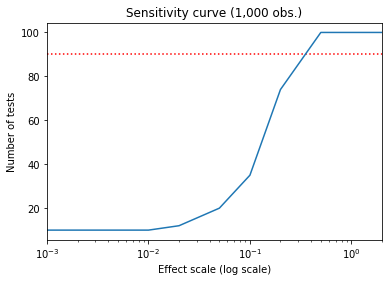

In [37]:
print(sensitivity_test.format_result())
sensitivity_test.display()

### Compute minimal difference

We actually do not have to iterate over sample `thresholds` to find the right value for a significant change. It would be more efficicent to process by dichotomy, either over the list or on absolute values. More simply, it is faster to run the AA-test; the ratio between the upper bound and the difference is the minimal effect that would make the test significant.

In [38]:
def find_detected_diff(self):
    min_detection = self.t_test.cr_c + self.t_test.conf_interval[1]
    self.detected_diff = (min_detection/self.t_test.cr_t) - 1
    return self.detected_diff

ABTest.find_detected_diff = find_detected_diff

### Verification

Let’s check that the treatment conversion increased by this minimum boost gives the exact value of the upper limit.

In [39]:
events = generate_events()
segment = generate_segment_from_events(events)
aa_test = ABTest(events, segment)
aa_test.compute()
vars(aa_test.t_test)

{'totals': segment    event_type 
 control    conversion     131
            observation    481
 treatment  conversion     153
            observation    519
 Name: segment, dtype: int64,
 'alpha': 0.1,
 'observation': 1000,
 'cr_c': 0.27234927234927236,
 'cr_t': 0.2947976878612717,
 'difference': 0.02244841551199933,
 'rel_diff': 0.0824250981776464,
 'stddev': 0.0285055991474319,
 'z': (-1.6448536269514729, 1.6448536269514722),
 'conf_interval': (-0.04688753814607817, 0.046887538146078156),
 'significant': False,
 'result': 'Draw',
 't': 0.7875089871254901,
 'p': 0.21558547731604039}

In [40]:
import math
print(aa_test.totals)
sensitivity = aa_test.find_detected_diff()
print(sensitivity)
aa_test.totals.treatment.conversion = math.ceil(
    aa_test.totals.treatment.conversion.astype(float) \
    * (1 + sensitivity)
)
aa_test.t_test.compute()
vars(aa_test.t_test)

segment    event_type 
control    conversion     131
           observation    481
treatment  conversion     153
           observation    519
Name: segment, dtype: int64
0.0829013375626595


{'totals': segment    event_type 
 control    conversion     131
            observation    481
 treatment  conversion     166
            observation    519
 Name: segment, dtype: int64,
 'alpha': 0.1,
 'observation': 1000,
 'cr_c': 0.27234927234927236,
 'cr_t': 0.3198458574181118,
 'difference': 0.047496585068839414,
 'rel_diff': 0.17439585815352487,
 'stddev': 0.028829973954243606,
 'z': (-1.6448536269514729, 1.6448536269514722),
 'conf_interval': (-0.04742108722355409, 0.04742108722355407),
 'significant': True,
 'result': 'Win',
 't': 1.6474723544399246,
 'p': 0.049887890020213765}

Let’s see how that faster and more accurate approach runs on our sample

In [41]:
sensitivity_test.run_batch(n_steps=4, run_per_step=125)
print(sensitivity_test.format_result())

After 500 runs, we estimate that this test should reliably (90%) detect improvements of at least 29.4%


### Test sensitivity with observations

Let’s now consider an test with more observations than just 1,000.

In [42]:
more_sensitive_test = SensitivityTest(generate_events(n_obs=10_000))
more_sensitive_test.run_batch(n_steps=4, run_per_step=125)

0.09478606871192263

In [43]:
most_sensitive_test = SensitivityTest(generate_events(n_obs=100_000))
most_sensitive_test.run_batch(n_steps=4, run_per_step=125)

0.028234950681393034

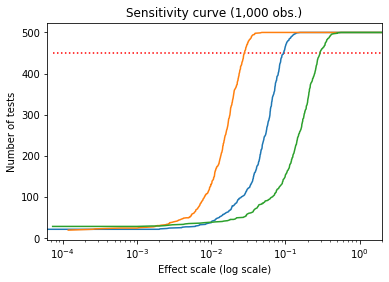

In [44]:
def multi_display(tests):    
    for test in tests[1:]:
        val = test.cum_dist.index
        test.cum_dist[val > 0].plot(logx=True)
    tests[0].display()
    pass

tests = [sensitivity_test, more_sensitive_test, most_sensitive_test]
multi_display(tests)

Tests on small samples are less sensitive to minor changes.

We already knew that testing on smaller samples means our false positive rate $\alpha$ is harder to confirm _cf._ [AA-tests](#aa-test). _I.e._ We can’t control the quality of our test as well. Does this mean that, our prediction of the test sensitivity is but less reliable too?

Let’s explore that by running multiple sensitivity tests on samples of different sizes.

In [45]:
def compute_multiple_curves(events, n_curve=100):
    list_sensitivity_test = []
    for i in range(n_curve):
        list_sensitivity_test.append(SensitivityTest(events))
        list_sensitivity_test[i].run_batch()        
    return list_sensitivity_test

list_sensitivity_test = compute_multiple_curves(events)

In [46]:
def display_multiple_curves(
    list_sensitivity_test, 
    color="blue", transparency=0.1, 
    padding=1.3, x_scale="linear"
):    
    n_tests = len(list_sensitivity_test)
    n_runs = list_sensitivity_test[0].n_runs
    n_obs = list_sensitivity_test[0].test.t_test.observation

    list_min_significant = []
    for sensitive_test in list_sensitivity_test:
        list_min_significant.append(sensitive_test.min_significant)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))
    ax1.set(
        title="{0:,} sensitivity tests ({1:,} obs.)".format(n_tests, n_obs),
        xlabel="Difference size",
        ylabel="Number of AA-tests",
    )    
    if x_scale == "linear":
        x_lim = (0, max(list_min_significant)*padding)
        ax1.set_xlim(x_lim)
    if x_scale == "log":        
        ax1.set_xscale('log')
        x_lim = (val[val > 0], max(val))
        ax1.set_xlim(x_lim)
    ax1.hlines(list_sensitivity_test[0].reliable,
              x_lim[0], x_lim[1],
              color="red", linestyles="dotted")
    for sensitive_test in list_sensitivity_test:
        cum_dist = sensitive_test.cum_dist
        val = cum_dist.index
        use = (val > x_lim[0]) & (val < x_lim[1])
        ax1.plot(cum_dist[use], color=color, alpha=transparency)
    x_ticks = ax1.get_xticks()
    ax1.set_xticklabels(['{:,.0%}'.format(x) for x in x_ticks])
    
    ax2.hist(list_min_significant)
    x_ticks = ax2.get_xticks()
    ax2.set_xticklabels(['{:,.0%}'.format(x) for x in x_ticks])
    x = np.linspace(min(x_ticks), max(x_ticks), 20)
    m = np.mean(list_min_significant)
    s = np.std(list_min_significant)
    ax2.plot(x, norm.pdf(x, m, s))
    ax2.set(
        title="Minimum difference reliably detectable",
        xlabel="Reliably ({0:.0%}) detectable difference".format(1-alpha),
        ylabel="Number of Sensitivity tests",
    )    

    plt.show()

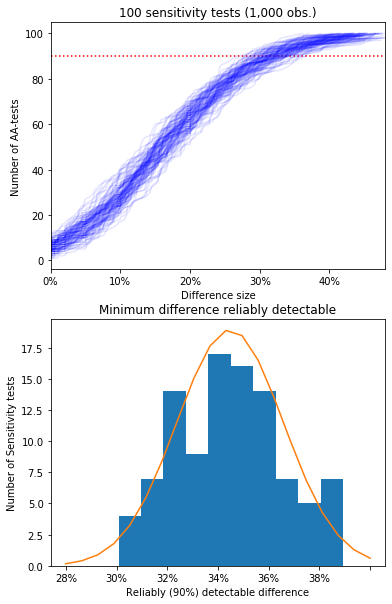

In [47]:
display_multiple_curves(list_sensitivity_test)

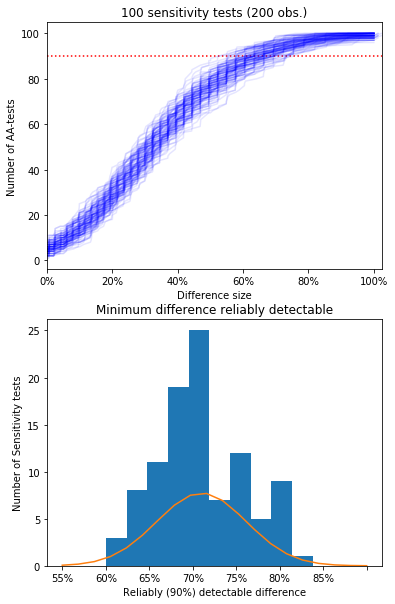

In [54]:
list_less_sensitivity_test = compute_multiple_curves(
    generate_events(n_obs=200),
)
display_multiple_curves(list_less_sensitivity_test)

## Small samples

Let’s take an extreme example (10 observations, 10% conversion rate) and see how our code fails on such a small sample.

In [48]:
def try_small_sample(cr=.2, n_obs=20, n_try=4):
    for i in range(n_try):
        events = generate_events(cr=cr, n_obs=n_obs)
        # cr=.3, n_users=400, n_obs=1_000, pp=.4
        batch_aa_test = BatchAATest(events)
        try:
            batch_aa_test.run_batch(n_steps=1, run_per_step=1000)
            batch_aa_test.display()
        except Exception as e:
            print(type(e).__name__, e)
            print(batch_aa_test.test.totals)
            break

In [49]:
try_small_sample()

AttributeError 'Series' object has no attribute 'conversion'
segment    event_type 
control    observation     8
treatment  conversion      4
           observation    12
Name: segment, dtype: int64


### Introduce data quality tests

If n_users < 100, then random segments might not include both active users assigned to `control` or `treatment`. We want to check that there are enough in both segments to run a test.

In [55]:
# TODO: Handle more than a binary control/treatment split

def is_segment_balanced(self, min_ratio=.4):    
    try:
        oc = self.totals.control.observation
        ot = self.totals.treatment.observation
        min_ratio = (oc + ot) * min_ratio
        balanced = (min(oc, ot) >= min_ratio)
        
        cc = self.totals.control.conversion
        ct = self.totals.treatment.conversion
        conversion_exist = (cc > 0) & (ct > 0)
        
        self.balanced = balanced & conversion_exist
    except:
        self.balanced = False
    return self.balanced

ABTest.is_segment_balanced = is_segment_balanced

In [ ]:
def test_with_random_segment(self, verbose=False):
    self.balanced = False
    while self.balanced is False:
        self.segment = generate_segment_from_events(self.events)
        self.test = ABTest(self.events, self.segment)        
        self.test.totals = compute_totals(self.events, self.segment)
        self.balanced = self.test.is_segment_balanced()
        if verbose and not self.balanced:
            print("Segment not balanced", self.test.totals)
    self.test.t_test = TTest(self.test.totals)
    self.test.t_test.compute()
    self.test.decision = self.test.t_test.format_decision()
    return self.test

BatchAATest.test_with_random_segment = test_with_random_segment

In [56]:
try_small_sample()

120 false positives over 1000 AA-tests.
We measure a false positive rate between 10.3% and 13.7%.
This is not consistent with our rate set at 10.0%. 
16 false positives over 1000 AA-tests.
We measure a false positive rate between 0.9% and 2.3%.
This is not consistent with our rate set at 10.0%. 
2 false positives over 1000 AA-tests.
We measure a false positive rate between -0.0% and 0.4%.
This is not consistent with our rate set at 10.0%. 
0 false positives over 1000 AA-tests.
We measure a false positive rate between 0.0% and 0.0%.
This is not consistent with our rate set at 10.0%. 


Tests on samples as small as 20 (to be split in two) have terrible behaviour but our edited `BatchAATest.test_with_random_segment()` iterates until we had segments that respect basic rules (`balanced` and `conversion_exist`).

If our constraints on segment are more constrained, we can reject some randomised splits to make sure the test is sensical. Let’s see what those constrained can be in practice.

## Units in groups

Imagine you have 1,000 users to split, but they belong to 100 cities and you want to make sure the distribution in each segment per city is reasonnable.

In [ ]:
# Build `country_id` in `events`

### Swaps

Segments are less random that way.


In [ ]:
# - Find the main difference
# - Identify a unit that could address that
# - Iterate

## Units of a certain scale

Imagine you are testing per city. An similar number of city doesn’t means the sample is balanced — not if city size is based on a Zipf law.

What’s the impact of re-balancing on sensitivity?

In [ ]:

# Build `shop_id` in `events`

### Swaps

Segments are less random that way.


In [ ]:
# - Find the main unbalance between segments of shops
# - Identify a shop that could address that
# - Iterate

With small samples, our confidence interval for $\alpha$ is often far from expectations. 

When dealing with small samples, check the false positive rates. Make sure that you are comfortable with how large they can be. That’s one of the issues with smaller samples: results are less reliable -- unless you are checking a large change. Let’s look into that.

### Issue with small samples

1. Less sensitive overall: use observations as a Bayesian update
1. Less able to check for sensitivity and false positives
1. There might not be 10,000 good, possible random samples


# Complications


## Unit selection with AA tests
<a name="unit_selection"></a>

### Choosing a test unit on web traffic: observation, session, user, country

Our `event` only knows about `user_id`. Let’s see what happens when we include realistic observations, session and countries in addition to users. 

In [53]:
def generate_user_country(users):
    
def generate_user_country(users):
    

class ABTest(ABTest):
    def __init__(self):
        self.col_names = ["event_timestamp", "user_id", "session_id", "event_type", "segment", "device_type"]
        self.col_types = ['datetime64', 'int', 'int', 'category', 'category', 'category']
        self.specify_type()

# def generate_observation_and_conversion(
#     conversion_rate = 0.3,
#     nb_users= 400,
#     nb_events = 1000,
#     pareto_parameter_conversion_delay = .4,
# ):
#     """
#     Given parameters about a population,
#     Returns a list of random events, with a possible conversion and delay
#     """
#     random_dates = pd.Series(np.random.random(size=(nb_events)))
#     random_dates = random_dates.apply(date_from_value)
#     random_users = pd.Series(np.random.randint(nb_users, size=(nb_events)))
#     random_convs = pd.Series(np.random.rand(nb_events) < conversion_rate)
#     random_conv_delay = pd.Series(np.random.pareto(
#         pareto_parameter_conversion_delay, size=(nb_events)
#     ))
#     random_events = pd.concat([
#         random_dates, random_users, random_convs, random_conv_delay,
#     ], axis=1, sort=False)
#     random_events.columns = ["event_timestamp", "user_id", "conversion", "conversion_delay",]
#     return random_events        
        
# def generate_events(cr=.3, n_users=400, n_obs=1_000, pp=.4):
#     """
#     Given optional key parameters about an set of events
#     Return a sample set of events with observations and conversions
#     """
#     observation = generate_observation_and_conversion(cr, n_users, n_obs, pp)
#     convertions = generate_conversion_from_observation(observation)
#     observation = observation[["event_timestamp", "user_id"]]
#     observation = observation.assign(event_type = "observation")
#     convertions = convertions.assign(event_type = "conversion")
#     events = pd.concat([observation, convertions], axis=0)    
#     events = events.sort_values(by=["event_timestamp"]).reset_index(drop=True)
#     return events        
        

IndentationError: expected an indented block (<ipython-input-53-12429157b608>, line 3)

What we did in the first part wasn’t appropriate:
- we randomised the segment per `user_id`;
- the metric was a ratio on the number of `observation`.

You should randomise per the same unit that you are testing, in case your metric is correlated with the difference between the two.

Using smaller units can increase the sensitivity of the test, but it raises concerns about user experience: they might prefer consistency.

In [ ]:
### Exclude double-exposed users?

### Why things are not what it seems

Detailed about user aspects

In [ ]:
# observation, session, user

In [ ]:
# sites and company

# Shuffling because size difference

In [ ]:
class TestSample:
    def __init__(self):
        self.segment = pd.DataFrame([])
        self.sample_size = 0
        self.nb_observations = 0
        self.nb_conversions = 0
    
    def generate_random(
        self,
        sample_size=10_000,
        segment_names=['Control', 'Treatment'],
        conversion_rate=0.3,
    ):  
        nb_segments = len(segment_names)
        event = EventData(sample_size)
        # segment = segment_names
        
    def remove_inconsistencies(self):
        pass
    def detect_inconsistencies(self):
        pass

In [ ]:
# for each unit type
#   for 10_000
#     run function that does aa_test
# show outcome

### Unit selection with Sensitivity


In [ ]:
# for each unit type
#   for 10_000
#     run function that does sensitivity
# show outcome

### Why the discrepancy? Correlation

In typical web traffic data, there are correlations between session and observation and conversion rates.


## Identification after the fact
<a name="id_post_exposure"></a>

Imagine some users go through the site without identification. They are treated as a distinct users first, and could be exposed to another experience.


In [ ]:
# def users_log_in_after_fact():
# 

### Double-exposure

If that is the case, we have to exclude them.

In [ ]:
# def exclude_double_exposure()

This reduces significance if you have a large number of non-logged in users.

## Multiple overlaping experiments
<a name="overlap"></a>

### Risk of overlap


### Detecting interference and exclusion

## Multiple overlaping experiments

### Multi-variate testing 

<a name="multi-variate_test"></a>

Distinct from (additive) multi-variable test: ABC-test.

Multiplicative: A-A', A-B', B-A', B-B'.
Four way test? Detect significant difference between (A * A') and A-A'

# Test on Small samples

# Test on Small samples
<a name="small_sample"></a>

## Random assignment: imprecise


## Smart shuffle to optimise split
<a name="reshuffle"></a>

## Control for unit type and activity level
<a name="type_activity"></a>

### Type

Is the activity level correlated with the conversion rate? Would the test likely have different impact on each level?

In [ ]:
# modify the session data to include type

If we try to re-sample to optimise for balanced type

In [ ]:
# Re-shuffle and re-test

### Activity level

Is the activity level correlated with the conversion rate? Would the test likely have different impact on each level?

In [ ]:
# session data already has activity level

If we try to re-sample to optimise for balanced activity level

In [ ]:
# Re-shuffle and re-test

## Exclude outliers
<a name="outliers"></a>

Sometimes, some units have so much activity that you can’t swap to balance the samples. In this case, it’s reasonnable to consider that those units can’t be properly tested.


## Observations as a Bayesian update

### Different level with uneven size

# Summary
<a name="summary"></a>

You can test on small samples, but it’s less sensitive:
- consider the **relevant unit** carefully;
- run **sensitivity testing**;
- swap or exclude units to **optimise** the split;
- **control** for activity, type.

### Other great content

- [Detailed advice on common testing issues](https://towardsdatascience.com/chasing-statistical-ghosts-in-experimentation-3f393323a1c1) from Lizzie Eardley, with Colin McFarland and Tom Oliver of SkyScanner;
- [Guidelines for AB testing](https://robinsones.github.io/Guidelines-for-AB-Testing/) from Emily Robinson of Etsy and DataCamp;
- [Fully detailed code](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f) from Nguyen Ngo of TowardsDataScience;
- [Arguments for a Bayesian approach](https://medium.com/convoy-tech/the-power-of-bayesian-a-b-testing-f859d2219d5) from Michael Frasco of Convoy and for  
  [a mixed frequentist and Bayesian approach](https://www.convertize.com/ab-test-significance/) from Philippe Aimé of Convertize.